# Distinquishing between pooping dogs and non-pooping dogs using machine learning

### Table of contents
1. [Dataset](#introduction)
2. [Labeling with Amazon SageMaker Ground Truth](#groundtruth)
3. [Reviewing labeling results](#review)
4. [Training an Object Detection model](#training)
5. [Review of Training Results](#review_training)
6. [Model Tuning](#model_tuning)
7. [Cleanup](#cleanup)


<a name="introduction"></a>
## Dataset
Our dataset is sourced from popular search engines. The images need to be synced from the s3 bucket to the notebook.

In [62]:
BUCKET = 'deeplens-sagemaker-poopinator'
PREFIX = 'working' # root path working space
labeling_job_name = 'dog-obj2'
training_job_name = 'poopinator-detection-resnet'
local_working_dir = 'working'
local_manifest_dir = local_working_dir + '/manifests'

In [70]:
!aws s3 sync s3://$BUCKET/images images

## Labeling with SageMaker Ground Truth <a name="groundtruth"></a>

We need to create a Ground Truth job to label our images. Once the labeling job is complete we can proceed with the next section of the notebook.

## Reviewing labeling results
<a name="reviewing"></a>


After the labeling job is complete we can review the results to verfiy the images were labeled correctly.

Next we plot the annotated images. We display the images from the notebook and draw the bounding boxes from the labeling job on top of them.

In [74]:
import boto3
client = boto3.client('sagemaker')

s3_output = client.describe_labeling_job(LabelingJobName=labeling_job_name)['OutputConfig']['S3OutputPath'] + labeling_job_name
augmented_manifest_url = f'{s3_output}/manifests/output/output.manifest'

import os
import shutil

try:
    os.makedirs(local_manifest_dir, exist_ok=False)
except FileExistsError:
    shutil.rmtree(local_manifest_dir)

augmented_manifest_file = local_manifest_dir + '/output.manifest'
!aws s3 cp $augmented_manifest_url $augmented_manifest_file
!head -3 $augmented_manifest_file

download: s3://dogpoop/dog-obj2/manifests/output/output.manifest to working/manifests/output.manifest
{"source-ref":"s3://dogpoop/dataset/00000.jpg","dog-obj2":{"annotations":[{"class_id":0,"width":468,"top":79,"height":373,"left":259}],"image_size":[{"width":960,"depth":3,"height":540}]},"dog-obj2-metadata":{"job-name":"labeling-job/dog-obj2","class-map":{"0":"pooping"},"human-annotated":"yes","objects":[{"confidence":0.09}],"creation-date":"2020-01-28T23:30:39.156040","type":"groundtruth/object-detection"}}
{"source-ref":"s3://dogpoop/dataset/00001.jpg","dog-obj2":{"annotations":[{"class_id":0,"width":590,"top":2,"height":428,"left":102}],"image_size":[{"width":760,"depth":3,"height":430}]},"dog-obj2-metadata":{"job-name":"labeling-job/dog-obj2","class-map":{"0":"pooping"},"human-annotated":"yes","objects":[{"confidence":0.09}],"creation-date":"2020-01-28T23:21:19.008426","type":"groundtruth/object-detection"}}
{"source-ref":"s3://dogpoop/dataset/00002.jpg","dog-obj2":{"annotations":

In [75]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from itertools import cycle

def show_annotated_image(img_path, bboxes, prec):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['r', 'o', 'b', 'g', 'c', 'm', 'k', 'w'])
    
    right = .1
    bottom = .9
    
    for bbox in bboxes:
        
        if bbox['class_id'] == 0:
            class_id = 'pooping'
            text_color = 'red'
        elif bbox['class_id'] == 1:
            class_id = 'not_pooping'
            text_color = 'orange'
            
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1,edgecolor=text_color,facecolor='none')
     
        # Add the patch to the Axes
        ax.add_patch(rect)
        if float(prec) == 1:
            ax.text(right, bottom, class_id,
            horizontalalignment='left',
            verticalalignment='top',
            color=text_color,
            backgroundcolor='white',
            transform=ax.transAxes)
        elif float(prec) < 1:
            ax.text(right, bottom, class_id + '\n' + prec + '%',
            horizontalalignment='left',
            verticalalignment='top',
            color=text_color,
            backgroundcolor='white',
            transform=ax.transAxes)

    plt.show()

Read the augmented manifest line by line and display the first 10 images.

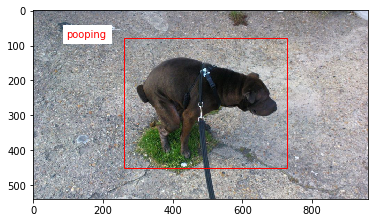

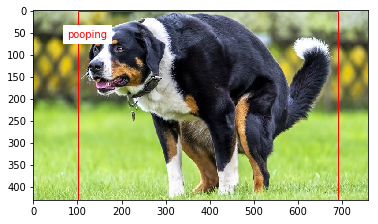

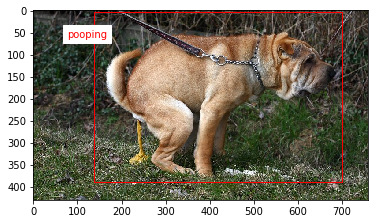

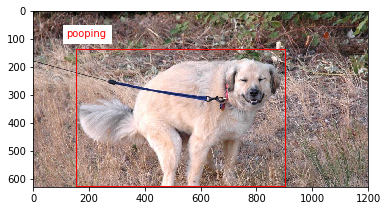

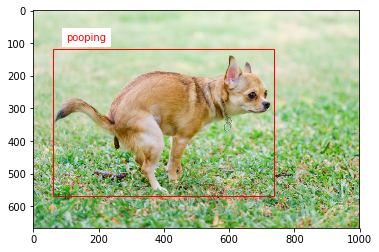

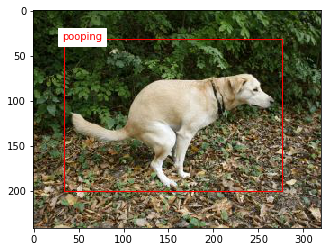

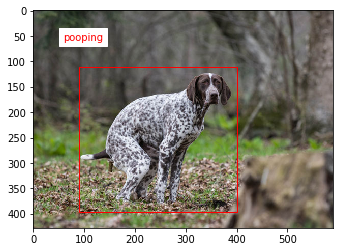

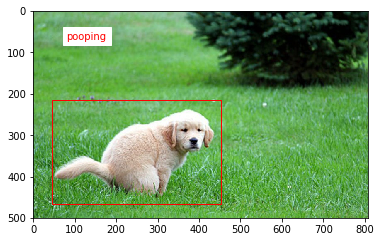

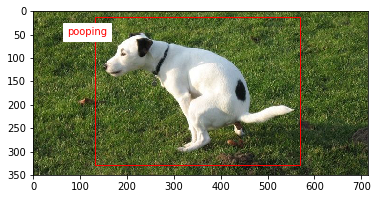

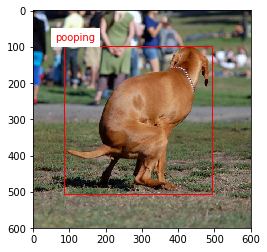

In [78]:
### The PIP install stuff only needs to run once, it should probably be moved to a Lifecycle script ###
!pip -q install --upgrade pip
!pip -q install jsonlines
import jsonlines
from itertools import islice
    
with jsonlines.open(augmented_manifest_file, 'r') as reader:
    for desc in islice(reader, 10):
        img_url = desc['source-ref']
        img_file = "images/source/" + os.path.basename(img_url)
        file_exists = os.path.isfile(img_file)
        bboxes = desc[labeling_job_name]['annotations']
        show_annotated_image(img_file, bboxes, 1)

<a name='training'></a>
## Training an Object Detection Model
We are now ready to use the labeled dataset in order to train a Machine Learning model using the SageMaker [built-in Object Detection algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).

In [79]:
import json

augmented_manifest_filename_output = local_manifest_dir + '/output.manifest'

with jsonlines.open(augmented_manifest_filename_output, 'r') as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.shuffle(lines)
    
dataset_size = len(lines)
num_training_samples = round(dataset_size*0.9)

train_data = lines[:num_training_samples]
validation_data = lines[num_training_samples:]

augmented_manifest_filename_train = local_manifest_dir + '/train.manifest'

with open(augmented_manifest_filename_train, 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_validation = local_manifest_dir + '/validation.manifest'

with open(augmented_manifest_filename_validation, 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')
        
print(f'training samples: {num_training_samples}, validation samples: {len(lines)-num_training_samples}')

training samples: 199, validation samples: 22


Next, let's upload the two manifest files to S3 in preparation for training.

In [80]:
pfx_training = PREFIX + '/training' if PREFIX else 'training'
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_validation)

!aws s3 cp $augmented_manifest_filename_train s3://$BUCKET/$pfx_training/
!aws s3 cp $augmented_manifest_filename_validation s3://$BUCKET/$pfx_training/

upload: working/manifests/train.manifest to s3://deeplens-sagemaker-poopinator/working/training/train.manifest
upload: working/manifests/validation.manifest to s3://deeplens-sagemaker-poopinator/working/training/validation.manifest


We are ready to start the training job in the SageMaker console. Notebook code option below.

In [16]:
import time
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

training_image = sagemaker.amazon.amazon_estimator.get_image_uri(
    boto3.Session().region_name, 'object-detection', repo_version='latest')
s3_output_path = 's3://{}/{}/output'.format(BUCKET, pfx_training)

training_params = \
    {
        "AlgorithmSpecification": {
            # NB. This is one of the named constants defined in the first cell.
            "TrainingImage": training_image,
            "TrainingInputMode": "Pipe"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": s3_output_path
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": "ml.p2.xlarge",
            "VolumeSizeInGB": 50
        },
        "TrainingJobName": training_job_name,
        "HyperParameters": {  # NB. These hyperparameters are at the user's discretion and are beyond the scope of this demo.
            "base_network": "resnet-50",
            "use_pretrained_model": "1",
            "num_classes": "2",
            "mini_batch_size": "1",
            "epochs": "100",
            "learning_rate": "0.001",
            "lr_scheduler_step": "",
            "lr_scheduler_factor": "0.1",
            "optimizer": "sgd",
            "momentum": "0.9",
            "weight_decay": "0.0005",
            "overlap_threshold": "0.5",
            "nms_threshold": "0.45",
            "image_shape": "300",
            "label_width": "350",
            "num_training_samples": str(num_training_samples)
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 86400
        },
        "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_train_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        # NB. This must correspond to the JSON field names in your augmented manifest.
                        "AttributeNames": ['source-ref', labeling_job_name]
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            },
            {
                "ChannelName": "validation",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_validation_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        # NB. This must correspond to the JSON field names in your augmented manifest.
                        "AttributeNames": ['source-ref', labeling_job_name]
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            }
        ]
    }

# Now we create the SageMaker training job.
client = boto3.client(service_name='sagemaker')
client.create_training_job(**training_params)

# Confirm that the training job has started
status = client.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

Training job current status: InProgress


To check the progess of the training job, you can refresh the console or repeatedly evaluate the following cell. When the training job status reads `'Completed'`, move on to the next part of the tutorial.

In [81]:
import boto3
client = boto3.client('sagemaker')

training_info = client.describe_training_job(TrainingJobName=training_job_name)

print("Training job status: ", training_info['TrainingJobStatus'])
print("Secondary status: ", training_info['SecondaryStatus'])

Training job status:  Completed
Secondary status:  Completed


<a name='review_training'></a>

## Review of Training Results

First, let's create the SageMaker model out of model artifacts

In [82]:
import time
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name = training_job_name + '-model' + timestamp

training_image = training_info['AlgorithmSpecification']['TrainingImage']
model_data = training_info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

from sagemaker import get_execution_role

role = get_execution_role()

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-1:530820723481:model/poopinator-detection-resnet-model-2020-07-09-01-11-18


In [83]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = training_job_name + '-epc' + timestamp
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: poopinator-detection-resnet-epc-2020-07-09-01-11-30
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:530820723481:endpoint-config/poopinator-detection-resnet-epc-2020-07-09-01-11-30


### Create Endpoint

The next cell creates an endpoint that can be validated and incorporated into production applications. This takes about 10 minutes to complete.

In [84]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = training_job_name + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: poopinator-detection-resnet-ep-2020-07-09-01-11-39
EndpointArn = arn:aws:sagemaker:us-east-1:530820723481:endpoint/poopinator-detection-resnet-ep-2020-07-09-01-11-39


In [89]:
response = client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

EndpointStatus = InService


### Perform inference

In [90]:
import glob
test_images = glob.glob('images/test/*')
print(*test_images, sep="\n")

images/test/t0001.jpg
images/test/t0009.jpg
images/test/t0006.jpg
images/test/t0002.jpg
images/test/t0000.jpg
images/test/t0004.jpg
images/test/t0007.jpg
images/test/t0003.jpg
images/test/t0008.jpg
images/test/t0005.jpg


In [91]:
def prediction_to_bbox_data(image_path, prediction):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

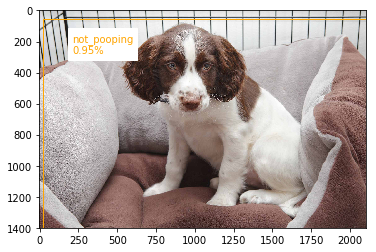

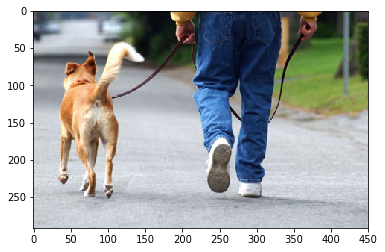

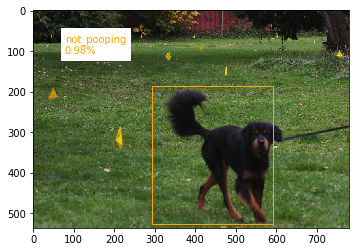

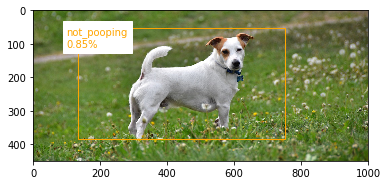

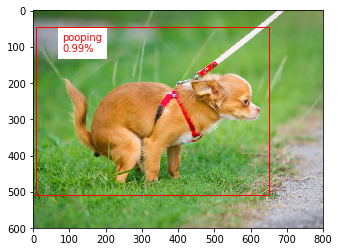

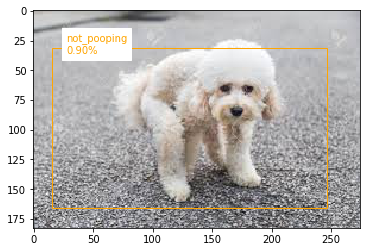

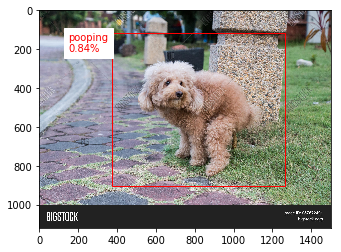

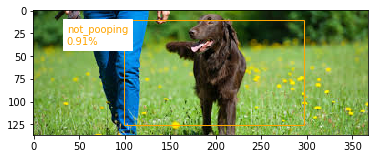

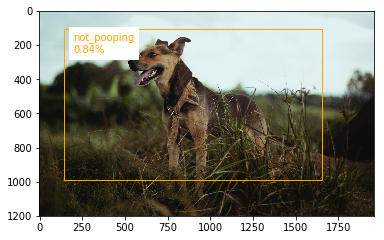

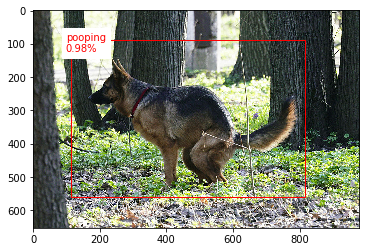

In [92]:
import matplotlib.pyplot as plt
runtime_client = boto3.client('sagemaker-runtime')
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')
    
for test_image in test_images:
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .03
    best_n = 1
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    
    for prediction in predictions[:best_n]:
        prediction_list = sorted(prediction, reverse = True)
    for item in sorted(prediction, reverse = True):
        if item == 1.0:
            try:
                prediction_list.remove(item)
            except:
                print("")
    conf_precision3 = str(prediction_list[0])[0] + str(prediction_list[0])[1] + str(prediction_list[0])[2] + str(prediction_list[0])[3]
    
    show_annotated_image(test_image, bboxes, conf_precision3)

<a name='model_tuning'></a>
## Model Tuning

When you configured the training job you needed to add many hyperparameters that affect the performance of the algorithm and the quality of the resulting model. But how do you pick the right hyperparameters?

If you have experience with the specific algorithm and understand the innerworkings of it, you may already have a good sense of appropriate values. But even then, it's impossible to know the exact best value of each hyperparameter. Often you can zero in on the best values by trying many different combination of values, effectively searching in the hyperparameter space. SageMaker makes this extremely easy with the Model Tuning feature, also known as Hyperparameter Optimization (or HPO). With Model Tuning you simply decide which of the hyperparameters you are not sure about and specify the range of values for each that SageMaker needs to explore. Let's see again how this can be accomplished via the console.

This is a placeholder for future exploration.


<a name='model_optimization'></a>
## Model Optimization

In order to deploy the MXNet model to AWS DeepLens, the model artifacts must be optimized. This currently involves running a depricated deploy.py script which has recently been removed from the mxnet-incubator source. We will clone mxnet-incubator to the notebook, then checkout an earlier revision.

Next we somewhat ungracefully unpack the model, rename files, and optimize the model. We then repack the mdel into a new file and upload to s3 where we can import it into a DeepLens model.

In [93]:
### Git cloning should be wrapped in an if statement that determines if the directory already exists, or moved to a Lifecycle script ###
!cd lib && git clone https://github.com/apache/incubator-mxnet.git
!aws s3 cp s3://$s3_output_path/$training_job_name/output/model.tar.gz working/model/model-orig.tar.gz

Cloning into 'incubator-mxnet'...
remote: Enumerating objects: 119498, done.
remote: Total 119498 (delta 0), reused 0 (delta 0), pack-reused 119498
Receiving objects: 100% (119498/119498), 82.71 MiB | 35.25 MiB/s, done.
Resolving deltas: 100% (82773/82773), done.
fatal error: Parameter validation failed:
Invalid bucket name "s3:": Bucket name must match the regex "^[a-zA-Z0-9.\-_]{1,255}$" or be an ARN matching the regex "^arn:(aws).*:s3:[a-z\-0-9]+:[0-9]{12}:accesspoint[/:][a-zA-Z0-9\-]{1,63}$"


In [94]:
### This command rolls back to the commit before they removed the deploy.py script. ###
!cd lib/incubator-mxnet && git checkout 26f44b71d8de84bbc88af496ae0aeb7ce535312d

Note: checking out '26f44b71d8de84bbc88af496ae0aeb7ce535312d'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 26f44b71d... Add backward Type inference to main NN operators (#18378)


In [102]:
### Unpack the model and move the files into a tmp directory ###
!cd working/model/tmp && tar xvfpz ../model.tar.gz.orig
!cd working/model/tmp && mv model_algo_1-0000.params model_resnet50_300-0100.params
!cd working/model/tmp && mv model_algo_1-symbol.json model_resnet50_300-symbol.json

model_algo_1-symbol.json
hyperparams.json
model_algo_1-0000.params


In [103]:
### Extract the model artifacts and optimize them for DeepLens ###
!cd working/model/tmp && python3 ../../../lib/incubator-mxnet/example/ssd/deploy.py --network resnet50 --data-shape 300 --num-class 2 --epoch 100 --prefix model_

[01:50:35] src/nnvm/legacy_json_util.cc:209: Loading symbol saved by previous version v1.4.1. Attempting to upgrade...
[01:50:35] src/nnvm/legacy_json_util.cc:217: Symbol successfully upgraded!
Saved model: model_resnet50_300-0100.params
Saved symbol: model_resnet50_300-symbol.json


In [104]:
### Pack the model bak up into the model directory ###
!cd working/model/tmp && mv model_resnet50_300-0100.params model_resnet50_300-0000.params
!cd working/model/tmp && tar cvfz ../model.tar.gz model_resnet50_300-0000.params model_resnet50_300-symbol.json hyperparams.json

model_resnet50_300-0000.params
model_resnet50_300-symbol.json
hyperparams.json


In [107]:
!cd working/model && aws s3 cp model.tar.gz $s3_output_path/$training_job_name/output/model.tar.gz

upload: ./model.tar.gz to s3://deeplens-sagemaker-poopinator/working/training/output/poopinator-detection-resnet/output/model.tar.gz


<a name='cleanup'></a>
## Cleanup

Delete the endpoint to stop incurring costs

In [108]:
client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'b04db857-1d04-4791-8896-410b9958726e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b04db857-1d04-4791-8896-410b9958726e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 09 Jul 2020 01:56:18 GMT'},
  'RetryAttempts': 0}}